## Kalman Filter vs. Median Filter

This notebook is intended to evaluate whether to use a Kalman filter or median filter here.

In [1]:
%matplotlib inline

import numpy as np
import RPi.GPIO as GPIO
from ring_buffer import RingBuffer
import matplotlib.pyplot as plt

from ultrasonic_sensor import UltrasonicSensor

In [2]:
GPIO.cleanup()
sensor1 = UltrasonicSensor(
    trigger=4,
    echo=17,
)

/usr/local/lib/python3.4/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: No channels have been set up yet - nothing to clean up!  Try cleaning up at the end of your program instead!
  """Entry point for launching an IPython kernel.
/home/pi/measure-lib/ultrasonic_sensor.py:25: RuntimeWarning: This channel is already in use, continuing anyway.  Use GPIO.setwarnings(False) to disable warnings.
  GPIO.setup(self.trigger, GPIO.OUT)


# Collect Measurements

In [16]:
import time
def measure():
#     time.sleep(.001)
    return sensor1.distance()
# intial parameters
n_iter = 1000

sz = (n_iter,) # size of array
x = 35
z = [measure() for _ in range(n_iter)]

In [31]:
z = [x if x < 35 else 35 - (x - 35) for x in z]
z = [x for x in z if x > 0]
len(z)

882

(0, 831)

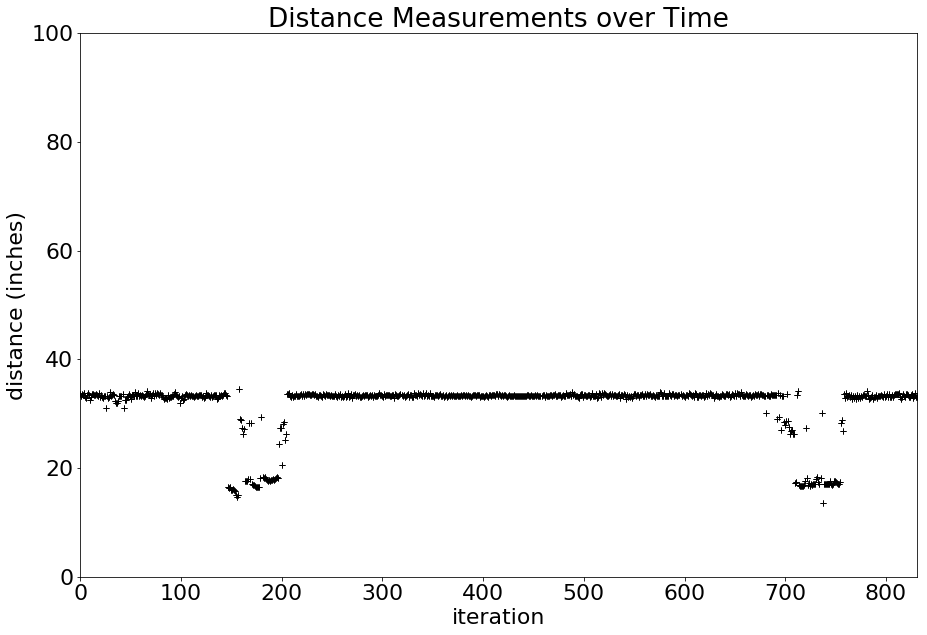

In [48]:
plt.rcParams['figure.figsize'] = (15, 10)
plt.figure()
plt.plot(z[50:],'k+',label='noisy measurements')
plt.title('Distance Measurements over Time')
plt.plot(z[50:],'k+',label='noisy measurements')
plt.xlabel('iteration')
plt.ylabel('distance (inches)')
plt.gca().set_ylim([0, 100])
plt.gca().set_xlim([0, len(z) - 51])

# Run Filters

In [44]:
Q = 1e-5 # process variance

# allocate space for arrays
xhat=np.zeros(sz)      # a posteri estimate of x
P=np.zeros(sz)         # a posteri error estimate
xhatminus=np.zeros(sz) # a priori estimate of x
Pminus=np.zeros(sz)    # a priori error estimate
K=np.zeros(sz)         # gain or blending factor

R = 50 # estimate of measurement variance, change to see effect

# intial guesses
xhat[0] = 0.0
P[0] = 1.0

for k in range(1,len(z)):
    # time update
    xhatminus[k] = xhat[k-1]
    Pminus[k] = P[k-1]+Q

    # measurement update
    K[k] = Pminus[k]/( Pminus[k]+R )
    xhat[k] = xhatminus[k]+K[k]*(z[k]-xhatminus[k])
    P[k] = (1-K[k])*Pminus[k]

In [40]:
history1 = RingBuffer(capacity=50, dtype=np.float)
median = []
for k in range(len(z)):
    history1.append(z[k])
    median.append(np.median(history1))

(0, 831)

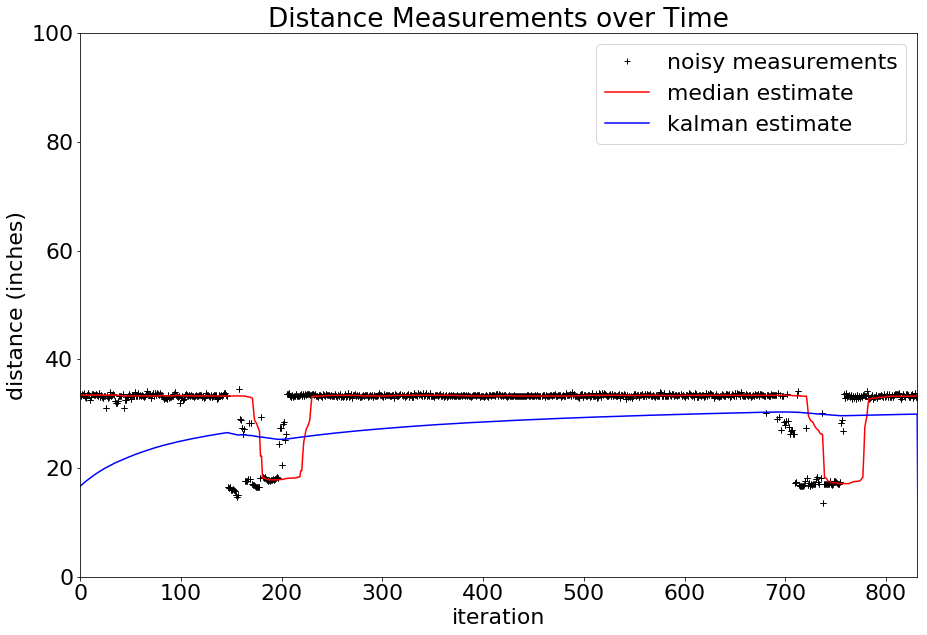

In [47]:
plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams.update({'font.size': 22})

plt.figure()
plt.plot(z[50:],'k+',label='noisy measurements')
plt.plot(z[50:],'k+',label='noisy measurements')
plt.plot(median[50:], 'r-', label='median estimate')
plt.plot(xhat[50:],'b-',label='kalman estimate')
plt.legend()
plt.title('Distance Measurements over Time')
plt.xlabel('iteration')
plt.ylabel('distance (inches)')
plt.gca().set_ylim([0, 100])
plt.gca().set_xlim([0, len(z) - 51])

In [ ]:
GPIO.cleanup()

In [49]:
from hmmlearn import hmm

model = hmm.GaussianHMM(
    n_components=2,
    covariance_type="diag",
)

In [52]:
model.fit(np.reshape(median[50:], (-1, 1)))

/usr/local/lib/python3.4/dist-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.4/dist-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.4/dist-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.4/dist-packages/sklearn/utils/deprecation.py:77: DeprecationWa

GaussianHMM(algorithm='viterbi', covariance_type='diag', covars_prior=0.01,
      covars_weight=1, init_params='stmc', means_prior=0, means_weight=0,
      min_covar=0.001, n_components=2, n_iter=10, params='stmc',
      random_state=None, startprob_prior=1.0, tol=0.01, transmat_prior=1.0,
      verbose=False)

In [54]:
preds = model.predict(np.reshape(median[50:], (-1, 1)))

/usr/local/lib/python3.4/dist-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


In [65]:
present = list(zip(*((idx, val) for idx, val in enumerate(median[50:]) if preds[idx] == 1)))
absent = list(zip(*((idx, val) for idx, val in enumerate(median[50:]) if preds[idx] == 0)))

(0, 831)

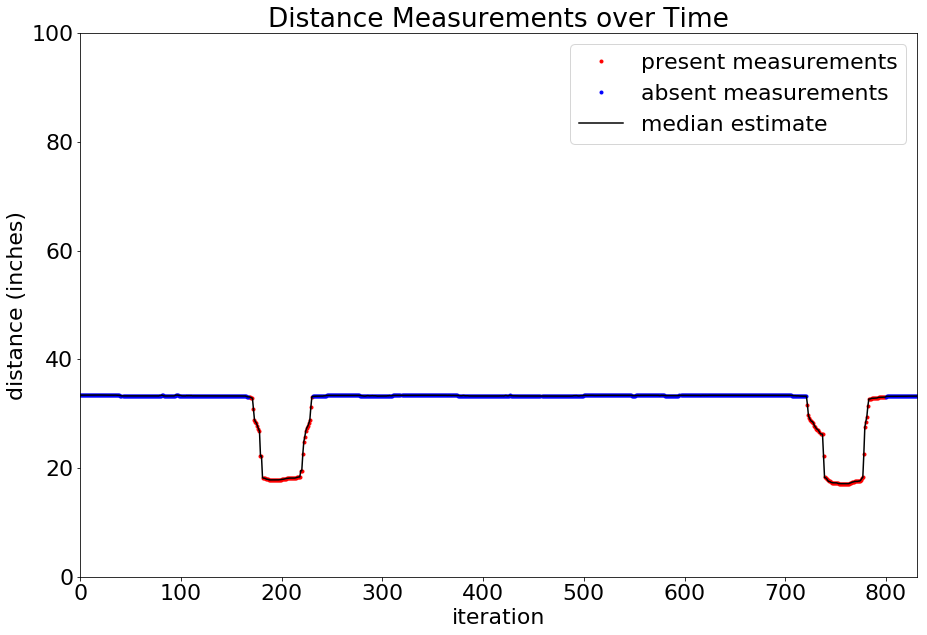

In [71]:
plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams.update({'font.size': 22})

plt.figure()
plt.plot(present[0], present[1],'r.',label='present measurements')
plt.plot(absent[0], absent[1],'b.',label='absent measurements')
plt.plot(median[50:], 'k-', label='median estimate')
plt.legend()
plt.title('Distance Measurements over Time')
plt.xlabel('iteration')
plt.ylabel('distance (inches)')
plt.gca().set_ylim([0, 100])
plt.gca().set_xlim([0, len(z) - 51])